In [1]:
%matplotlib inline

In [91]:
import numpy as np
from astropy import units as u

In [2]:
import pylab as pl
pl.rcParams['figure.figsize'] = (16,8)

In [15]:
import sys
sys.path.append('/lustre/naasc/users/aginsbur/repos/reduction/reduction/')
import imp, diagnostic_images
imp.reload(diagnostic_images)
from diagnostic_images import load_images, show

In [80]:
imgs_before_b6, cubes_before_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0')
imgs_after_b6, cubes_after_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal1')
imgs_after2_b6, cubes_after2_b6 = load_images('W51-E_B6_uid___A001_X1296_X215_continuum_merged_12M_robust0_selfcal2')

In the images below, the white contours show the region where the model is nonzero.

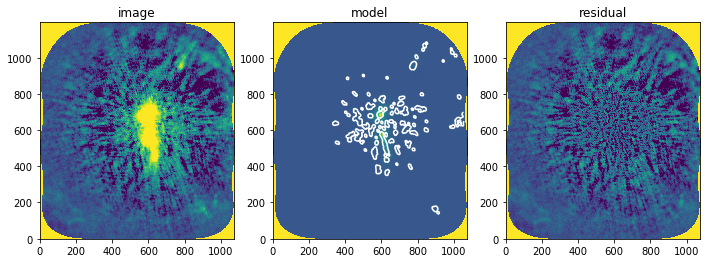

In [81]:
show(imgs_before_b6, vmin=-0.001, vmax=0.01)

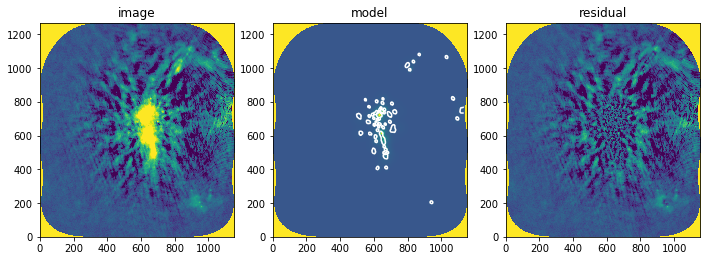

In [82]:
show(imgs_after_b6, vmin=-0.001, vmax=0.01)

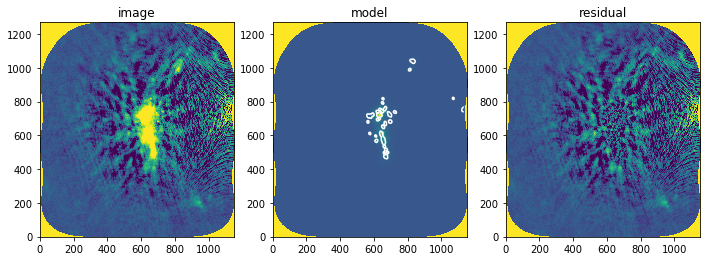

In [83]:
show(imgs_after2_b6, vmin=-0.001, vmax=0.01)

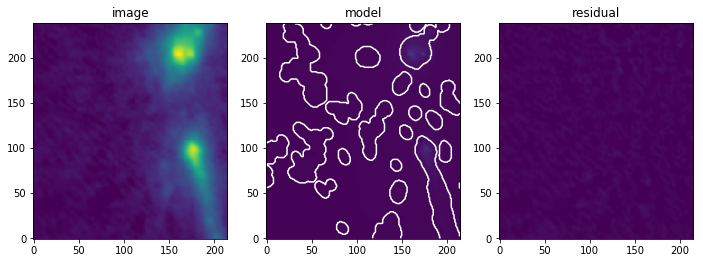

In [84]:
show(imgs_before_b6, vmin=-0.001, vmax=0.3, zoom=0.2)

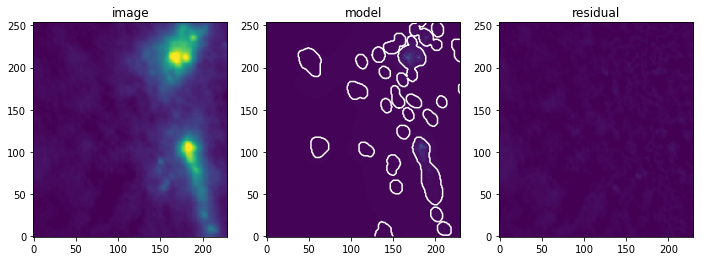

In [85]:
show(imgs_after_b6, vmin=-0.001, vmax=0.3, zoom=0.2)

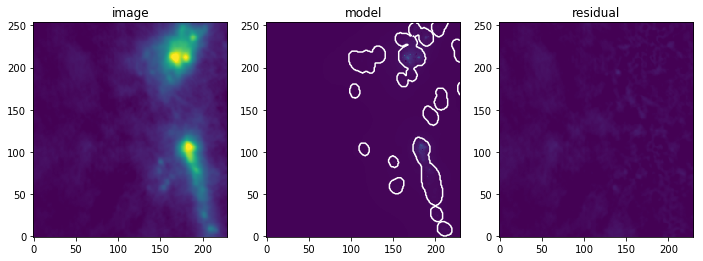

In [86]:
show(imgs_after2_b6, vmin=-0.001, vmax=0.3, zoom=0.2)

Calculate peak to RMS:

In [93]:
for imgs in (imgs_before_b6, imgs_after_b6, imgs_after2_b6):
    rms = np.nanstd(imgs['residual'].value*u.Jy/u.beam) # residual has bad header units
    peak = np.nanmax(imgs['image'].quantity)
    print(f"peak/rms = {peak/rms:0.1f}, peak={peak:0.3f}, rms={rms:0.4f}")

peak/rms = 426.0, peak=0.292 Jy / beam, rms=0.0007 Jy / beam
peak/rms = 620.7, peak=0.471 Jy / beam, rms=0.0008 Jy / beam
peak/rms = 311.1, peak=0.449 Jy / beam, rms=0.0014 Jy / beam


426->620 is good, 620->311 is very bad.  The RMS rose in both cases.  That's not great.

Examine the phases: this uses `casatools` (which is only available as a beta library from an NRAO site) to load the table and plot some simple phase information.

In [29]:
import casatools
tb = casatools.table()

# this creates a "context manager" for the table tool that automatically handles tb.open/tb.close operations
class CasaTable(object):
    def __init__(self, file_name):
        self.tb = tb
        self.file_obj = tb.open(file_name)
    def __enter__(self):
        return self.tb
    def __exit__(self, type, value, traceback):
        self.tb.close()

In [59]:
with CasaTable('../W51-E_B6_uid___A001_X1296_X215_continuum_merged_phase1_int.cal') as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    time = tb.getcol('TIME')
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')

['TIME', 'FIELD_ID', 'SPECTRAL_WINDOW_ID', 'ANTENNA1', 'ANTENNA2', 'INTERVAL', 'SCAN_NUMBER', 'OBSERVATION_ID', 'CPARAM', 'PARAMERR', 'FLAG', 'SNR', 'WEIGHT']


In [43]:
# data are complex numbers; we're interested in the phase angle
angle = np.angle(data) * 180/np.pi

Plot the phase angle correction from the calibration table vs. entry number.  This allows us to see the typical phase correction split by observation ID rather than by time, since it's very hard to see anything in the angle vs. time plot when multiple independent observations are involved.

In [65]:
uobsids = np.unique(obsid)
nobsids = len(uobsids)
print(nobsids)

13


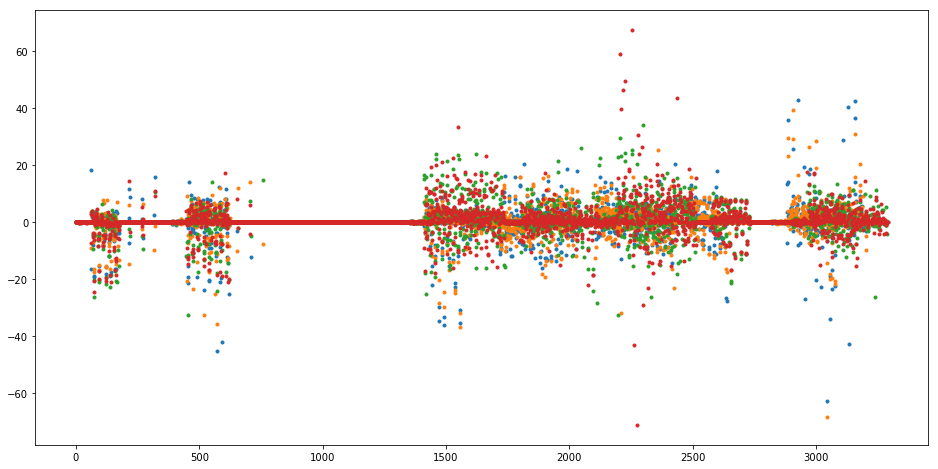

In [67]:
pl.plot(angle[:,0,(antenna1 == 0) & (spwid%13==0)].T, marker='.', linestyle='none')
pl.plot(angle[:,0,(antenna1 == 0) & (spwid%13==1)].T, marker='.', linestyle='none')

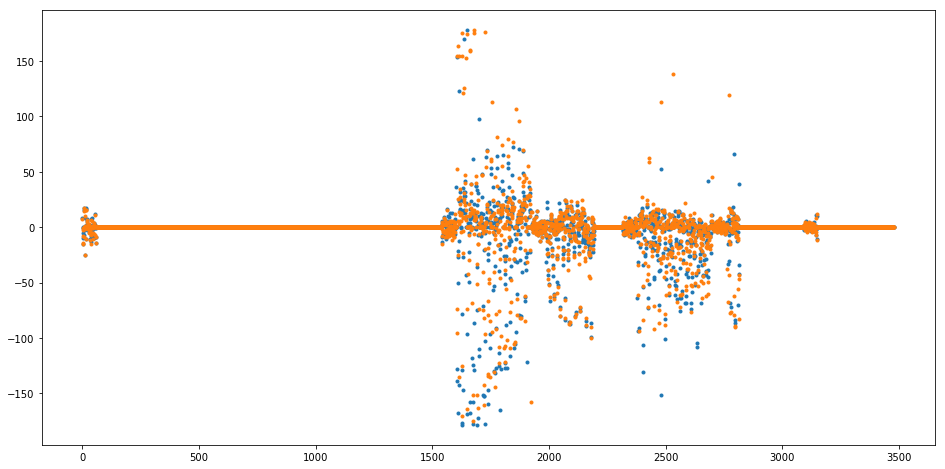

In [69]:
pl.plot(angle[:,0,(antenna1 == 2) & (spwid%13==3)].T, marker='.', linestyle='none')

In [70]:
uantid = np.unique(antenna1)
nants = len(uantid)
print(nants)

83


In [58]:
anglecube = angle.reshape([2,1,antenna1.shape//nants,nants])

This creates a "waterfall plot" of scan number on the y-axis vs antenna number on the x-axis.  You can then see the breakdown by what looks like 7m (lots of scans, few antennae), TM1 (medium # of scans) and TM2 (few scans)

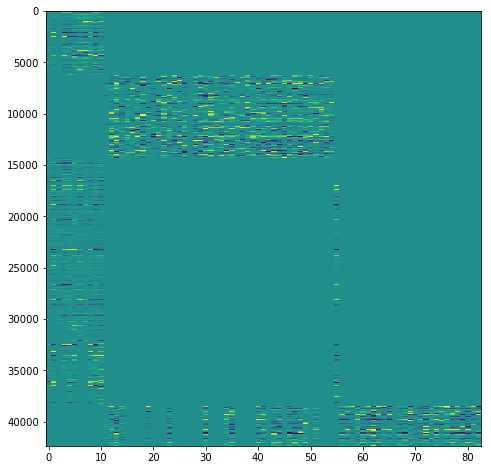

In [79]:
pl.imshow(anglecube[0,0,:,:], aspect=anglecube.shape[3]/anglecube.shape[2])

Because this is a live CASA notebook, we can do a gaincal with amplitude just to see what's going on.

In [94]:
from casatasks import gaincal

In [ ]:
ms = '../W51-E_B6_uid___A001_X1296_X215_continuum_merged_selfcal.ms'
gaincal(vis=ms, caltable='test_amplitude_gains_B6_W51E.cal',
        solint='inf', gaintype='G', calmode='a')

In [ ]:
with CasaTable('test_amplitude_gains_B6_W51E.cal') as tb:
    print(tb.colnames())
    data = tb.getcol('CPARAM')
    time = tb.getcol('TIME')
    antenna1 = tb.getcol('ANTENNA1')
    antenna2 = tb.getcol('ANTENNA2')
    obsid = tb.getcol('OBSERVATION_ID')
    spwid = tb.getcol('SPECTRAL_WINDOW_ID')